# Classifying PDF Documents with AutoMM


PDF comes short from Portable Document Format and is one of the most popular document formats.
We can find PDFs everywhere, from personal resumes to business contracts, and from commercial brochures to government documents.
The list can be endless.
PDF is highly praised for its portability.
There's no worry about the receiver being unable to view the document or see an imperfect version regardless of their operating system and device models.

Using AutoMM, you can handle and build machine learning models on PDF documents just like working on other modalities such as text and images, without bothering about PDFs processing.
In this tutorial, we will introduce how to classify PDF documents automatically with AutoMM using document foundation models. Let’s get started!

For document processing, AutoGluon requires poppler to be installed. Check https://poppler.freedesktop.org for source

https://github.com/oschwartz10612/poppler-windows for Windows release (make sure to add the bin/ folder to PATH after installing)

`brew install poppler` for Mac

## Get the PDF document dataset
We have created a simple PDFs dataset via manual crawling for demonstration purpose.
It consists of two categories, resume and historical documents (downloaded from [milestone documents](https://www.archives.gov/milestone-documents/list)).
We picked 20 PDF documents for each of the category.

Now, let's download the dataset and split it into training and test sets.

In [1]:
!pip install autogluon.multimodal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 657.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runti

In [1]:

!pip uninstall -y torchaudio
!pip install torchaudio

Found existing installation: torchaudio 2.4.0+cu121
Uninstalling torchaudio-2.4.0+cu121:
  Successfully uninstalled torchaudio-2.4.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
ERROR: pip's dependency resolver does n

In [2]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.4.1 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.19.1 which is incompatible.


In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from autogluon.core.utils.loaders import load_zip

download_dir = './ag_automm_tutorial_pdf_classifier'
zip_file = "https://automl-mm-bench.s3.amazonaws.com/doc_classification/pdf_docs_small.zip"
load_zip.unzip(zip_file, unzip_dir=download_dir)

dataset_path = os.path.join(download_dir, "pdf_docs_small")
pdf_docs = pd.read_csv(f"{dataset_path}/data.csv")
train_data = pdf_docs.sample(frac=0.8, random_state=200)
test_data = pdf_docs.drop(train_data.index)

100%|██████████| 12.7M/12.7M [00:01<00:00, 9.51MiB/s]


Now, let's visualize one of the PDF documents. Here, we use the S3 URL of the PDF document and `IFrame` to show it in the tutorial.

In [3]:
!apt-get install -y poppler-utils
!pip install pdf2image pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (337 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
import tempfile
import os
from pdf2image import convert_from_path
from IPython.display import Image, display
import requests
from pdf2image.exceptions import PDFInfoNotInstalledError

def display_pdf_as_images(pdf_url, pages=None):
    try:
        # Download the PDF
        response = requests.get(pdf_url)
        response.raise_for_status()  # Raises an HTTPError for bad responses

        with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as temp_file:
            temp_file.write(response.content)
            temp_file_path = temp_file.name

        try:
            # Convert PDF to list of images
            images = convert_from_path(temp_file_path, dpi=200, first_page=pages, last_page=pages)

            # Display images
            for i, image in enumerate(images):
                print(f"Page {i+1}")
                display(image)

        except PDFInfoNotInstalledError:
            print("Error: poppler-utils is not installed. Please run !apt-get install -y poppler-utils")
        except Exception as e:
            print(f"An error occurred while processing the PDF: {str(e)}")

        finally:
            # Clean up the temporary file
            os.unlink(temp_file_path)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the PDF: {str(e)}")

Page 1


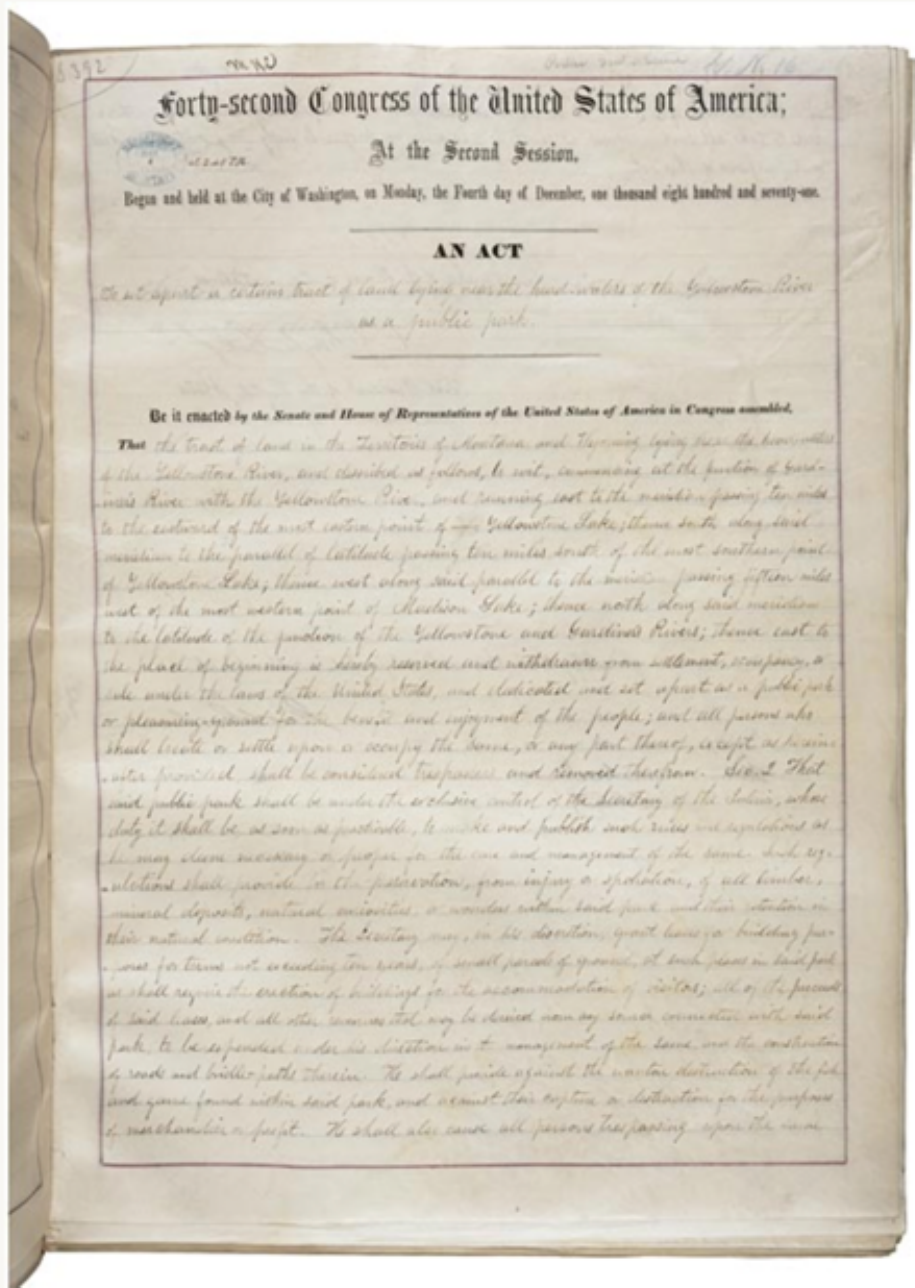

In [6]:
# Usage
pdf_url = "https://automl-mm-bench.s3.amazonaws.com/doc_classification/historical_1.pdf"
display_pdf_as_images(pdf_url, pages=1)  # Display only the first page

As you can see, this document is an America's historical document in PDF format.
To make sure the MultiModalPredictor can locate the documents correctly, we need to overwrite the document paths.

In [7]:
from autogluon.multimodal.utils.misc import path_expander

DOC_PATH_COL = "doc_path"

train_data[DOC_PATH_COL] = train_data[DOC_PATH_COL].apply(lambda ele: path_expander(ele, base_folder=download_dir))
test_data[DOC_PATH_COL] = test_data[DOC_PATH_COL].apply(lambda ele: path_expander(ele, base_folder=download_dir))
print(test_data.head())

                                             doc_path   label
4   /content/ag_automm_tutorial_pdf_classifier/pdf...  resume
12  /content/ag_automm_tutorial_pdf_classifier/pdf...  resume
14  /content/ag_automm_tutorial_pdf_classifier/pdf...  resume
15  /content/ag_automm_tutorial_pdf_classifier/pdf...  resume
16  /content/ag_automm_tutorial_pdf_classifier/pdf...  resume


## Create a PDF Document Classifier

You can create a PDFs classifier easily with `MultiModalPredictor`.
All you need to do is to create a predictor and fit it with the above training dataset.
AutoMM will handle all the details, like (1) detecting if it is PDF format datasets; (2) processing PDFs like converting it into a format that our model can recognize; (3) detecting and recognizing the text in PDF documents; etc., without your notice.

Here, label is the name of the column that contains the target variable to predict, e.g., it is “label” in our example.
We set the training time limit to 120 seconds for demonstration purposes.

In [8]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(label="label")
predictor.fit(
    train_data=train_data,
    hyperparameters={"model.document_transformer.checkpoint_name":"microsoft/layoutlm-base-uncased",
    "optimization.top_k_average_method":"best",
    },
    time_limit=120,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240915_230816"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       CUDA is not available
Memory Avail:       10.36 GB / 12.67 GB (81.7%)
Disk Space Avail:   65.02 GB / 107.72 GB (60.4%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['historical', 'resume']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```s

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/170 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | DocumentTransformer | 112 M  | train
1 | validation_metric | BinaryAUROC         | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------------
112 M     Trainable params
0         Non-trainable params
112 M     Total params
450.518   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:02:02. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240915_230816")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




## Evaluate on Test Dataset

You can evaluate the classifier on the test dataset to see how it performs:

In [9]:
scores = predictor.evaluate(test_data, metrics=["accuracy"])
print('The test acc: %.3f' % scores["accuracy"])

Predicting: |          | 0/? [00:00<?, ?it/s]

The test acc: 0.625


## Predict on a New PDF Document

Given an example PDF document, we can easily use the final model to predict the label:


In [10]:
predictions = predictor.predict({DOC_PATH_COL: [test_data.iloc[0][DOC_PATH_COL]]})
print(f"Ground-truth label: {test_data.iloc[0]['label']}, Prediction: {predictions}")


Predicting: |          | 0/? [00:00<?, ?it/s]

Ground-truth label: resume, Prediction: ['resume']


If probabilities of all categories are needed, you can call predict_proba:

In [11]:
proba = predictor.predict_proba({DOC_PATH_COL: [test_data.iloc[0][DOC_PATH_COL]]})
print(proba)

Predicting: |          | 0/? [00:00<?, ?it/s]

[[0.33786502 0.662135  ]]


## Extract Embeddings

Extracting representation from the whole document learned by a model is also very useful.
We provide extract_embedding function to allow predictor to return the N-dimensional document feature where N depends on the model.

In [12]:
feature = predictor.extract_embedding({DOC_PATH_COL: [test_data.iloc[0][DOC_PATH_COL]]})
print(feature[0].shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(768,)


## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).
